<a href="https://colab.research.google.com/github/guthi1/deep-learning/blob/main/Cours%20Courville/GRU_%26_Transformer/solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IFT6135-A2022
# Assignment 2: Practical

You must fill in your answers to various questions in this notebook, following which you must export this notebook to a Python file named `solution.py` and submit it on Gradescope.

**Make sure you request a GPU runtime!**

In [ ]:
# DO NOT MODIFY!
import math
import json
import time

import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext

device = "cuda" if torch.cuda.is_available() else "cpu"

def fix_experiment_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

fix_experiment_seed()

#### Data pre-processing

Run the cells below by clicking the Run/Play button, but do not modify the code.

In [ ]:
from collections import Counter
import io
import os
from torchtext.data.utils import get_tokenizer
from torchtext.utils import download_from_url, extract_archive

In [ ]:
os.system("python3 -m spacy download en_core_web_sm")
os.system("python3 -m spacy download fr_core_news_sm")

0

In [ ]:
en_tokenizer = torchtext.data.utils.get_tokenizer("spacy", "en_core_web_sm")
fr_tokenizer = torchtext.data.utils.get_tokenizer("spacy", "fr_core_news_sm")

In [ ]:
base_url = "https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/"
train_urls = ["train.en.gz", "train.fr.gz"]
val_urls = ["val.en.gz", "val.fr.gz"]
test_urls = ["test_2016_flickr.en.gz", "test_2016_flickr.fr.gz"]
train_paths = [extract_archive(download_from_url(base_url + url))[0] for url in train_urls]
val_paths = [extract_archive(download_from_url(base_url + url))[0] for url in val_urls]
test_paths = [extract_archive(download_from_url(base_url + url))[0] for url in test_urls]

In [ ]:
def generate_vocabulary(path, tokenizer):
    counter = Counter()
    with io.open(path, encoding="utf8") as f:
        for item in f:
            counter.update(tokenizer(item))
    vocabulary = torchtext.vocab.vocab(counter, specials=["<unk>", "<pad>", "<bos>", "<eos>"])
    vocabulary.set_default_index(vocabulary["<unk>"])
    return vocabulary

en_vocabulary = generate_vocabulary(train_paths[0], en_tokenizer)
fr_vocabulary = generate_vocabulary(train_paths[1], fr_tokenizer)

In [ ]:
def get_processed_data(paths):
    en_file_io = iter(io.open(paths[0], encoding="utf8"))
    fr_file_io = iter(io.open(paths[1], encoding="utf8"))
    data = []
    for en_item, fr_item in zip(en_file_io, fr_file_io):
        en_processed = torch.tensor([en_vocabulary[token] for token in en_tokenizer(en_item)], dtype=torch.long)
        fr_processed = torch.tensor([fr_vocabulary[token] for token in fr_tokenizer(fr_item)], dtype=torch.long)
        data.append((en_processed, fr_processed))
    return data

train_data = get_processed_data(train_paths)
val_data = get_processed_data(val_paths)
test_data = get_processed_data(test_paths)

In [ ]:
# N_EXEMPLE = 2

# en_file_io = iter(io.open(train_paths[0], encoding="utf8"))
# fr_file_io = iter(io.open(train_paths[1], encoding="utf8"))
# i = 1
# for en_item, fr_item in zip(en_file_io, fr_file_io):
#     en_processed = torch.tensor([en_vocabulary[token] for token in en_tokenizer(en_item)], dtype=torch.long)
#     print([token for token in en_tokenizer(en_item)])
#     fr_processed = torch.tensor([fr_vocabulary[token] for token in fr_tokenizer(fr_item)], dtype=torch.long)
#     print(f"Input {len(en_tokenizer(en_item))}: {en_tokenizer(en_item)}")
#     print(f"Token: {[token for token in en_tokenizer(en_item)]}")
#     voc = torch.tensor([en_vocabulary[token] for token in en_tokenizer(en_item)])
#     print(f"Vocabulary {len(voc)} : {voc}")

#     if i == N_EXEMPLE:
#         break

#     i += 1

### GRU Encoder-Decoder Model for Machine Translation

#### Dataloader

Running this cell will create `train_loader`, `val_loader` and `test_loader` for training, validation and testing respectively. The batch size is 128 and all sequences are of length 60 – shorter sequences are padded to this length. For this question, the data is provided in the shape `[sequence_length, batch_size]`. You need not modify this.

In [ ]:
special_idx = {
    "bos": en_vocabulary["<bos>"],
    "pad": en_vocabulary["<pad>"],
    "eos": en_vocabulary["<eos>"]
}

max_len = 60

def get_batch(data):
    en_batch_, fr_batch_ = [], []
    for en_item, fr_item in data:
        en_batch_.append(torch.cat([torch.tensor([special_idx["bos"]]), en_item, torch.tensor([special_idx["eos"]])], dim=0))
        fr_batch_.append(torch.cat([torch.tensor([special_idx["bos"]]), fr_item, torch.tensor([special_idx["eos"]])], dim=0))
    en_batch_ = nn.utils.rnn.pad_sequence(en_batch_, padding_value=special_idx["pad"])
    fr_batch_ = nn.utils.rnn.pad_sequence(fr_batch_, padding_value=special_idx["pad"])
    en_batch = torch.full((max_len, en_batch_.shape[1]), special_idx["pad"])
    en_batch[:en_batch_.shape[0], :] = en_batch_
    fr_batch = torch.full((max_len, fr_batch_.shape[1]), special_idx["pad"])
    fr_batch[:fr_batch_.shape[0], :] = fr_batch_
    return en_batch, fr_batch

batch_size = 128
if __name__ == "__main__":
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=get_batch)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True, collate_fn=get_batch)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, collate_fn=get_batch)

#### Encoder-Decoder Model

In [ ]:
class Encoder(nn.Module):
    """
    Defines an encoder model containing a GRU.
    """
    def __init__(
        self,
        vocabulary_size=10838, # Size of source vocabulary, given by len(en_vocabulary)
        embedding_size=32,     # Size of nn.Embedding
        hidden_size=64,        # Hidden size for nn.GRU
        num_layers=1,          # Number of layers in the nn.GRU
        use_dropout=False,     # Whether or not to use Dropout
        p_dropout=0.1          # Dropout probability
    ):
        super(Encoder, self).__init__()

        self.vocabulary_size = vocabulary_size
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.use_dropout = use_dropout

        # WRITE CODE HERE (for padding_idx, use special_idx["pad"])
        self.embedding = nn.Embedding(
            num_embeddings=vocabulary_size,
            embedding_dim=embedding_size,
            padding_idx=special_idx["pad"]
        ) 

        if self.use_dropout:
            # WRITE CODE HERE (use p_dropout)
            self.dropout = nn.Dropout(p_dropout) 

        # WRITE CODE HERE (set batch_first=False)
        self.gru = nn.GRU(
            input_size=embedding_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=False
        ) 

    def forward(self, x):
        # WRITE CODE HERE
        # x -> embedding -> dropout (if use_dropout) -> gru -> return output and final hidden
        x = self.embedding(x)
        if self.use_dropout:
            x = self.dropout(x)
        out, hidden = self.gru(x)
        return out, hidden

In [ ]:
class Decoder(nn.Module):
    """
    Defines a decoder model containing a GRU.
    """
    def __init__(
        self,
        vocabulary_size=11510, # Size of target vocabulary, given by len(fr_vocabulary)
        embedding_size=32,     # Size of nn.Embedding
        hidden_size=64,        # Hidden size for nn.GRU
        num_layers=1,          # Number of layers in the nn.GRU
        use_dropout=False,     # Whether or not to use Dropout
        p_dropout=0.1          # Dropout probability
    ):
        super(Decoder, self).__init__()

        self.vocabulary_size = vocabulary_size
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.use_dropout = use_dropout

        # WRITE CODE HERE
        self.embedding = nn.Embedding(
                vocabulary_size, 
                embedding_size
            ) 

        if self.use_dropout:
            # WRITE CODE HERE (use p_dropout)
            self.dropout = nn.Dropout(p_dropout) 

        # WRITE CODE HERE (set batch_first=False)
        self.gru = nn.GRU(
                input_size=embedding_size,
                hidden_size=hidden_size,
                num_layers=1,
                batch_first=False
            ) 

        self.fc = nn.Linear(hidden_size, vocabulary_size) # WRITE CODE HERE
    
    def forward(self, x, hidden):
        x = x.unsqueeze(0)

        # WRITE CODE HERE
        # x -> embedding -> dropout (if use_dropout) -> gru -> output and final hidden
        # output -> fc -> out
        # return out and final hidden

        x = self.embedding(x)
        x = self.dropout(x) if self.use_dropout else x
        out, hidden = self.gru(x, hidden)
        out = self.fc(out)

        return out.squeeze(), hidden

In [ ]:
class Seq2Seq(nn.Module):
    """
    Defines an encoder-decoder (sequence-to-sequence) model for machine translation.
    """
    def __init__(
        self,
        encoder,
        decoder,
        strategy="greedy"
    ):
        super(Seq2Seq, self).__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.strategy = strategy

    def forward(self, source, target):
        batch_size = source.shape[1]
        max_length = target.shape[0]
        target_vocabulary_size = self.decoder.vocabulary_size

        outputs = torch.zeros(max_length, batch_size, target_vocabulary_size).to(device)
        sentences = torch.zeros(max_length, batch_size).to(device)

        # WRITE CODE HERE
        # Get the encoder outputs and hidden state for the source sentences
        encoder_out, hidden = self.encoder.forward(source)

        # The first input token passed to the decoder is <bos>
        out = target[0, :]

        if self.strategy == "greedy":
            for idx in range(1, max_length):
                # WRITE CODE HERE
                # Get the decoder outputs and hidden state for the input token and hidden state
                out, hidden = self.decoder(out, hidden)

                outputs[idx] = out

                # WRITE CODE HERE
                # Reassign out with the greedy choice (argmax) for each batch
                # (batch_size, vocabulary_size) -> (batch_size)
                out = out.argmax(dim=1)

                sentences[idx] = out
        elif self.strategy == "random":
            temperature = 0.5
            for idx in range(1, max_length):
                # WRITE CODE HERE
                # Get the decoder outputs and hidden state for the input token and hidden state
                out, hidden = self.decoder(out, hidden)

                outputs[idx] = out

                # WRITE CODE HERE
                # Reassign out with the randomly sampled choice for each batch
                # p(x_i | x_{1:i-1}) =  exp(o_i / temperature) / sum(exp(o / temperature))
                # (batch_size, vocabulary_size) -> (batch_size)
                temperature = 0.5

                p = torch.nn.functional.softmax(out/temperature, dim=1)
                out = torch.multinomial(p, 1).squeeze()

                sentences[idx] = out
        else:
            raise Exception("Invalid decoding strategy!")

        return outputs, sentences

#### Training

In [ ]:
def get_criterion():
    # WRITE CODE HERE
    # The criterion must compute the cross-entropy loss but ignore special_idx["pad"].
    criterion = nn.CrossEntropyLoss(ignore_index=special_idx["pad"])
    return criterion

In [ ]:
def train(model, dataloader, optimizer, criterion):
    train_loss = 0.
    train_ppl = 0.
    model.train()
    start = time.time()

    for source, target in dataloader:
        source, target = source.to(device), target.to(device)

        optimizer.zero_grad()
        output, _ = model(source, target)
        output_reshape = output[1:].view(-1, output.shape[-1])
        target = target[1:].view(-1)
        loss = criterion(output_reshape, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    end = time.time()
    train_loss /= len(dataloader)
    train_ppl = math.exp(train_loss)
    train_time = end - start
    return train_loss, train_ppl, train_time

def validate(model, dataloader, criterion):
    val_loss = 0.
    val_ppl = 0.
    model.eval()
    start = time.time()

    for source, target in dataloader:
        source, target = source.to(device), target.to(device)

        output, _ = model(source, target)
        output_reshape = output[1:].view(-1, output.shape[-1])
        target = target[1:].view(-1)
        loss = criterion(output_reshape, target)
        val_loss += loss.item()

    end = time.time()
    val_loss /= len(dataloader)
    val_ppl = math.exp(val_loss)
    val_time = end - start
    return val_loss, val_ppl, val_time

def compute_bleu_gru(model, dataloader):
    targets = []
    translations = []

    for source, target in dataloader:
        source, target = source.to(device), target.to(device)

        _, output = model(source, target)
        for i in range(target.shape[1]):
            targets.append([[]])
            for token in target[1:, i]:
                if token in special_idx.values():
                    break
                targets[-1][0].append(fr_vocabulary.get_itos()[token])
            translations.append([])
            for token in output[1:, i]:
                if token in special_idx.values():
                    break
                translations[-1].append(fr_vocabulary.get_itos()[token.int().item()])

    return torchtext.data.metrics.bleu_score(translations, targets, max_n=1, weights=[1]) * 100, \
           torchtext.data.metrics.bleu_score(translations, targets, max_n=2, weights=[0.5]*2) * 100,

In [ ]:
fix_experiment_seed()
use_dropout = False
strategy = "greedy"
encoder = Encoder(use_dropout=use_dropout).to(device)
decoder = Decoder(use_dropout=use_dropout).to(device)
model = Seq2Seq(encoder, decoder, strategy=strategy).to(device)
optimizer = optim.Adam(model.parameters())
criterion = get_criterion()

results = {
    "train_losses": [],
    "train_ppls":   [],
    "train_times":  [],
    "valid_losses": [],
    "valid_ppls":   [],
    "valid_times":  [],
    "test_loss":    0.,
    "test_ppl":     0.,
    "test_bleu1":   0.,
    "test_bleu2":   0.,
    "test_time":    0.
}

if __name__ == "__main__":
    n_epochs = 10

    for epoch in range(n_epochs):
        train_loss, train_ppl, train_time = train(model, train_loader, optimizer, criterion)
        valid_loss, valid_ppl, valid_time = validate(model, val_loader, criterion)

        print(f"Epoch: {epoch}")
        print(f"Train Loss: {train_loss:.3f} | Train PPL: {train_ppl:7.3f} | Train Time: {train_time:.3f}")
        print(f"Valid Loss: {valid_loss:.3f} | Valid PPL: {valid_ppl:7.3f} | Valid Time: {valid_time:.3f}")

        results["train_losses"].append(train_loss)
        results["train_ppls"].append(train_ppl)
        results["train_times"].append(train_time)
        results["valid_losses"].append(valid_loss)
        results["valid_ppls"].append(valid_ppl)
        results["valid_times"].append(valid_time)

    test_loss, test_ppl, test_time = validate(model, test_loader, criterion)
    print(f"== Test Loss: {test_loss:.3f} | Test PPL: {test_ppl:7.3f} | Test Time: {test_time:.3f} ==")
    results["test_loss"] = test_loss
    results["test_ppl"] = test_ppl
    results["test_time"] = test_time

    results["test_bleu1"], results["test_bleu2"] = compute_bleu_gru(model, test_loader)
    print("Test BLEU-1:", results["test_bleu1"], "Test BLEU-2:", results["test_bleu2"])

    json.dump(results, open(f"seq2seq-adam-dropout_{str(use_dropout)}-strategy_{strategy}.json", "w"), indent=4)

Epoch: 0
Train Loss: 6.023 | Train PPL: 412.884 | Train Time: 87.118
Valid Loss: 5.125 | Valid PPL: 168.192 | Valid Time: 1.355
Epoch: 1
Train Loss: 5.062 | Train PPL: 157.861 | Train Time: 87.085
Valid Loss: 5.046 | Valid PPL: 155.342 | Valid Time: 1.339
Epoch: 2
Train Loss: 5.008 | Train PPL: 149.572 | Train Time: 87.161
Valid Loss: 5.023 | Valid PPL: 151.890 | Valid Time: 1.349
Epoch: 3
Train Loss: 4.985 | Train PPL: 146.167 | Train Time: 87.117
Valid Loss: 5.021 | Valid PPL: 151.536 | Valid Time: 1.348
Epoch: 4
Train Loss: 4.971 | Train PPL: 144.183 | Train Time: 87.560
Valid Loss: 5.017 | Valid PPL: 151.017 | Valid Time: 1.434
Epoch: 5
Train Loss: 4.963 | Train PPL: 142.954 | Train Time: 87.341
Valid Loss: 5.018 | Valid PPL: 151.169 | Valid Time: 1.362
Epoch: 6
Train Loss: 4.956 | Train PPL: 141.977 | Train Time: 87.161
Valid Loss: 5.019 | Valid PPL: 151.247 | Valid Time: 1.362
Epoch: 7
Train Loss: 4.950 | Train PPL: 141.228 | Train Time: 87.174
Valid Loss: 5.019 | Valid PPL: 151.

In [ ]:
fix_experiment_seed()
use_dropout = True
strategy = "greedy"
encoder = Encoder(use_dropout=use_dropout).to(device)
decoder = Decoder(use_dropout=use_dropout).to(device)
model = Seq2Seq(encoder, decoder, strategy=strategy).to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
criterion = get_criterion()

results = {
    "train_losses": [],
    "train_ppls":   [],
    "train_times":  [],
    "valid_losses": [],
    "valid_ppls":   [],
    "valid_times":  [],
    "test_loss":    0.,
    "test_ppl":     0.,
    "test_bleu1":   0.,
    "test_bleu2":   0.,
    "test_time":    0.
}

if __name__ == "__main__":
    n_epochs = 10

    for epoch in range(n_epochs):
        train_loss, train_ppl, train_time = train(model, train_loader, optimizer, criterion)
        valid_loss, valid_ppl, valid_time = validate(model, val_loader, criterion)

        print(f"Epoch: {epoch}")
        print(f"Train Loss: {train_loss:.3f} | Train PPL: {train_ppl:7.3f} | Train Time: {train_time:.3f}")
        print(f"Valid Loss: {valid_loss:.3f} | Valid PPL: {valid_ppl:7.3f} | Valid Time: {valid_time:.3f}")

        results["train_losses"].append(train_loss)
        results["train_ppls"].append(train_ppl)
        results["train_times"].append(train_time)
        results["valid_losses"].append(valid_loss)
        results["valid_ppls"].append(valid_ppl)
        results["valid_times"].append(valid_time)

    test_loss, test_ppl, test_time = validate(model, test_loader, criterion)
    print(f"== Test Loss: {test_loss:.3f} | Test PPL: {test_ppl:7.3f} | Test Time: {test_time:.3f} ==")
    results["test_loss"] = test_loss
    results["test_ppl"] = test_ppl
    results["test_time"] = test_time

    results["test_bleu1"], results["test_bleu2"] = compute_bleu_gru(model, test_loader)
    print("Test BLEU-1:", results["test_bleu1"], "Test BLEU-2:", results["test_bleu2"])

    json.dump(results, open(f"seq2seq-sgd-dropout_{str(use_dropout)}-strategy_{strategy}.json", "w"), indent=4)

Epoch: 0
Train Loss: 9.308 | Train PPL: 11029.010 | Train Time: 87.480
Valid Loss: 9.248 | Valid PPL: 10383.806 | Valid Time: 1.373
Epoch: 1
Train Loss: 9.132 | Train PPL: 9245.380 | Train Time: 87.546
Valid Loss: 8.715 | Valid PPL: 6090.888 | Valid Time: 1.342
Epoch: 2
Train Loss: 8.122 | Train PPL: 3366.543 | Train Time: 87.416
Valid Loss: 7.611 | Valid PPL: 2019.696 | Valid Time: 1.359
Epoch: 3
Train Loss: 7.565 | Train PPL: 1929.451 | Train Time: 87.483
Valid Loss: 7.388 | Valid PPL: 1616.506 | Valid Time: 1.376
Epoch: 4
Train Loss: 7.175 | Train PPL: 1306.021 | Train Time: 87.477
Valid Loss: 7.023 | Valid PPL: 1122.478 | Valid Time: 1.360
Epoch: 5
Train Loss: 6.901 | Train PPL: 993.585 | Train Time: 87.493
Valid Loss: 6.798 | Valid PPL: 895.692 | Valid Time: 1.346
Epoch: 6
Train Loss: 6.712 | Train PPL: 822.402 | Train Time: 87.484
Valid Loss: 6.632 | Valid PPL: 759.335 | Valid Time: 1.373
Epoch: 7
Train Loss: 6.580 | Train PPL: 720.492 | Train Time: 87.429
Valid Loss: 6.523 | Val

In [ ]:
fix_experiment_seed()
use_dropout = True
strategy = "greedy"
encoder = Encoder(use_dropout=use_dropout).to(device)
decoder = Decoder(use_dropout=use_dropout).to(device)
model = Seq2Seq(encoder, decoder, strategy=strategy).to(device)
optimizer = optim.Adam(model.parameters())
criterion = get_criterion()

results = {
    "train_losses": [],
    "train_ppls":   [],
    "train_times":  [],
    "valid_losses": [],
    "valid_ppls":   [],
    "valid_times":  [],
    "test_loss":    0.,
    "test_ppl":     0.,
    "test_bleu1":   0.,
    "test_bleu2":   0.,
    "test_time":    0.
}

if __name__ == "__main__":
    n_epochs = 10

    for epoch in range(n_epochs):
        train_loss, train_ppl, train_time = train(model, train_loader, optimizer, criterion)
        valid_loss, valid_ppl, valid_time = validate(model, val_loader, criterion)

        print(f"Epoch: {epoch}")
        print(f"Train Loss: {train_loss:.3f} | Train PPL: {train_ppl:7.3f} | Train Time: {train_time:.3f}")
        print(f"Valid Loss: {valid_loss:.3f} | Valid PPL: {valid_ppl:7.3f} | Valid Time: {valid_time:.3f}")

        results["train_losses"].append(train_loss)
        results["train_ppls"].append(train_ppl)
        results["train_times"].append(train_time)
        results["valid_losses"].append(valid_loss)
        results["valid_ppls"].append(valid_ppl)
        results["valid_times"].append(valid_time)

    test_loss, test_ppl, test_time = validate(model, test_loader, criterion)
    print(f"== Test Loss: {test_loss:.3f} | Test PPL: {test_ppl:7.3f} | Test Time: {test_time:.3f} ==")
    results["test_loss"] = test_loss
    results["test_ppl"] = test_ppl
    results["test_time"] = test_time

    results["test_bleu1"], results["test_bleu2"] = compute_bleu_gru(model, test_loader)
    print("Test BLEU-1:", results["test_bleu1"], "Test BLEU-2:", results["test_bleu2"])

    json.dump(results, open(f"seq2seq-adam-dropout_{str(use_dropout)}-strategy_{strategy}.json", "w"), indent=4)

Epoch: 0
Train Loss: 5.889 | Train PPL: 361.086 | Train Time: 90.357
Valid Loss: 5.103 | Valid PPL: 164.547 | Valid Time: 1.371
Epoch: 1
Train Loss: 5.048 | Train PPL: 155.746 | Train Time: 88.490
Valid Loss: 5.039 | Valid PPL: 154.278 | Valid Time: 1.370
Epoch: 2
Train Loss: 5.001 | Train PPL: 148.632 | Train Time: 88.219
Valid Loss: 5.022 | Valid PPL: 151.766 | Valid Time: 1.364
Epoch: 3
Train Loss: 4.982 | Train PPL: 145.770 | Train Time: 87.820
Valid Loss: 5.021 | Valid PPL: 151.617 | Valid Time: 1.402
Epoch: 4
Train Loss: 4.970 | Train PPL: 144.010 | Train Time: 88.264
Valid Loss: 5.019 | Valid PPL: 151.295 | Valid Time: 1.380
Epoch: 5
Train Loss: 4.962 | Train PPL: 142.881 | Train Time: 88.113
Valid Loss: 5.021 | Valid PPL: 151.575 | Valid Time: 1.372
Epoch: 6
Train Loss: 4.955 | Train PPL: 141.951 | Train Time: 88.145
Valid Loss: 5.021 | Valid PPL: 151.544 | Valid Time: 1.375
Epoch: 7
Train Loss: 4.950 | Train PPL: 141.221 | Train Time: 88.115
Valid Loss: 5.021 | Valid PPL: 151.

In [ ]:
fix_experiment_seed()
use_dropout = True
strategy = "random"
encoder = Encoder(use_dropout=use_dropout).to(device)
decoder = Decoder(use_dropout=use_dropout).to(device)
model = Seq2Seq(encoder, decoder, strategy=strategy).to(device)
optimizer = optim.Adam(model.parameters())
criterion = get_criterion()

results = {
    "train_losses": [],
    "train_ppls":   [],
    "train_times":  [],
    "valid_losses": [],
    "valid_ppls":   [],
    "valid_times":  [],
    "test_loss":    0.,
    "test_ppl":     0.,
    "test_bleu1":   0.,
    "test_bleu2":   0.,
    "test_time":    0.
}

if __name__ == "__main__":
    n_epochs = 10

    for epoch in range(n_epochs):
        train_loss, train_ppl, train_time = train(model, train_loader, optimizer, criterion)
        valid_loss, valid_ppl, valid_time = validate(model, val_loader, criterion)

        print(f"Epoch: {epoch}")
        print(f"Train Loss: {train_loss:.3f} | Train PPL: {train_ppl:7.3f} | Train Time: {train_time:.3f}")
        print(f"Valid Loss: {valid_loss:.3f} | Valid PPL: {valid_ppl:7.3f} | Valid Time: {valid_time:.3f}")

        results["train_losses"].append(train_loss)
        results["train_ppls"].append(train_ppl)
        results["train_times"].append(train_time)
        results["valid_losses"].append(valid_loss)
        results["valid_ppls"].append(valid_ppl)
        results["valid_times"].append(valid_time)

    test_loss, test_ppl, test_time = validate(model, test_loader, criterion)
    print(f"== Test Loss: {test_loss:.3f} | Test PPL: {test_ppl:7.3f} | Test Time: {test_time:.3f} ==")
    results["test_loss"] = test_loss
    results["test_ppl"] = test_ppl
    results["test_time"] = test_time

    results["test_bleu1"], results["test_bleu2"] = compute_bleu_gru(model, test_loader)
    print("Test BLEU-1:", results["test_bleu1"], "Test BLEU-2:", results["test_bleu2"])

    json.dump(results, open(f"seq2seq-adam-dropout_{str(use_dropout)}-strategy_{strategy}.json", "w"), indent=4)

Epoch: 0
Train Loss: 5.937 | Train PPL: 378.653 | Train Time: 93.312
Valid Loss: 5.160 | Valid PPL: 174.095 | Valid Time: 1.557
Epoch: 1
Train Loss: 5.080 | Train PPL: 160.729 | Train Time: 93.260
Valid Loss: 5.059 | Valid PPL: 157.414 | Valid Time: 1.553
Epoch: 2
Train Loss: 5.023 | Train PPL: 151.885 | Train Time: 93.399
Valid Loss: 5.037 | Valid PPL: 154.014 | Valid Time: 1.558
Epoch: 3
Train Loss: 5.001 | Train PPL: 148.547 | Train Time: 93.217
Valid Loss: 5.034 | Valid PPL: 153.554 | Valid Time: 1.566
Epoch: 4
Train Loss: 4.987 | Train PPL: 146.454 | Train Time: 93.179
Valid Loss: 5.028 | Valid PPL: 152.635 | Valid Time: 1.570
Epoch: 5
Train Loss: 4.916 | Train PPL: 136.403 | Train Time: 93.355
Valid Loss: 4.847 | Valid PPL: 127.356 | Valid Time: 1.606
Epoch: 6
Train Loss: 4.734 | Train PPL: 113.735 | Train Time: 93.307
Valid Loss: 4.762 | Valid PPL: 116.965 | Valid Time: 1.568
Epoch: 7
Train Loss: 4.640 | Train PPL: 103.579 | Train Time: 93.234
Valid Loss: 4.663 | Valid PPL: 105.

#### Basic Tests

In [ ]:
class TestSeq2SeqShapes():
    def __init__(self):
        self.vocabulary_size = 11
        self.embedding_size = 13
        self.hidden_size = 17
        self.num_layers = 1

        self.encoder = Encoder(
            vocabulary_size=self.vocabulary_size,
            embedding_size=self.embedding_size,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            use_dropout=False,
            p_dropout=0.1
        )
        self.decoder = Decoder(
            vocabulary_size=self.vocabulary_size,
            embedding_size=self.embedding_size,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            use_dropout=False,
            p_dropout=0.1
        )
        self.model = Seq2Seq(
            self.encoder, self.decoder, strategy="random"
        )

    def test_forward_shape(self):
        batch_size = 5
        sequence_length = 7
        tokens = torch.randint(self.vocabulary_size, size=(sequence_length, batch_size))

        outputs = self.encoder(tokens)

        assert isinstance(outputs, (tuple, list)), (
            "The output of the module must be encoder_outputs, hidden_state."
        )
        assert len(outputs) == 2, (
            "The output of the module must be encoder_outputs, hidden_state."
        )

        out, h = outputs

        expected_shape = (1, batch_size, self.hidden_size)
        assert isinstance(h, torch.Tensor), (
            "The hidden_state must be a torch.Tensor."
        )
        assert h.shape == expected_shape, (
            "The shape of `hidden_state` is invalid. Got shape {0}"
            "\n  Expected shape: {1}\n Recall that the final hidden_state should have shape "
            "(1, batch_size, hidden_size)".format(
                tuple(h.shape), expected_shape
            )
        )

        outputs = self.decoder(tokens[0, :], h)

        expected_shape = (batch_size, self.vocabulary_size)
        assert isinstance(outputs, (tuple, list)), (
            "The output of the module must ba a tuple scores, hidden_state."
        )
        assert len(outputs) == 2, (
            "The output of the module must ba a tuple scores, hidden_state."
        )

        out, h = outputs

        assert out.shape == expected_shape, (
            "The shape of decoder output is invalid. Got shape {0}."
            "\n  Expected shape: {1}\n Recall that the output should have shape "
            "(batch_size, vocabulary_size)".format(
                tuple(out.shape), expected_shape
            )
        )
        assert h.shape == (1, batch_size, self.hidden_size), (
            "The shape of final hidden state is invalid. Got shape {0}."
            "\n  Expected shape: {1}\n Recall that the output should have shape "
            "(1, batch_size, hidden_size)".format(
                tuple(h.shape), (1, batch_size, self.hidden_size)
            )
        )

        o, s = self.model(tokens, tokens)

        assert o.shape == (sequence_length, batch_size, self.vocabulary_size), (
            "The shape of Seq2Seq output is invalid. Got shape {0}."
            "\n  Expected shape: {1}\n Recall that the output should have shape "
            "(sequence_length, batch_size, vocabulary_size)".format(
                tuple(o.shape), (sequence_length, batch_size, self.vocabulary_size)
            )
        )

        assert s.shape == (sequence_length, batch_size), (
            "The shape of Seq2Seq sentences is invalid. Got shape {0}."
            "\n  Expected shape: {1}\n Recall that this should have shape "
            "(sequence_length, batch_size)".format(
                tuple(s.shape), (sequence_length, batch_size)
            )
        )

if __name__ == "__main__":
    TestSeq2SeqShapes().test_forward_shape()

### Transformer Encoder-Decoder Model for Machine Translation

#### Dataloader

Running this cell will create `train_loader`, `val_loader` and `test_loader` for training, validation and testing respectively. The batch size is 128 and all sequences are of length 60 – shorter sequences are padded to this length. For this question, the data is provided in the shape `[batch_size, sequence_length]`. You need not modify this.

In [ ]:
special_idx = {
    "bos": en_vocabulary["<bos>"],
    "pad": en_vocabulary["<pad>"],
    "eos": en_vocabulary["<eos>"]
}

max_len = 60

def get_batch(data):
    en_batch_, fr_batch_ = [], []
    for en_item, fr_item in data:
        en_batch_.append(torch.cat([torch.tensor([special_idx["bos"]]), en_item, torch.tensor([special_idx["eos"]])], dim=0))
        fr_batch_.append(torch.cat([torch.tensor([special_idx["bos"]]), fr_item, torch.tensor([special_idx["eos"]])], dim=0))
    en_batch_ = nn.utils.rnn.pad_sequence(en_batch_, padding_value=special_idx["pad"], batch_first=True)
    fr_batch_ = nn.utils.rnn.pad_sequence(fr_batch_, padding_value=special_idx["pad"], batch_first=True)
    en_batch = torch.full((en_batch_.shape[0], max_len), special_idx["pad"])
    en_batch[:, :en_batch_.shape[1]] = en_batch_
    fr_batch = torch.full((fr_batch_.shape[0], max_len), special_idx["pad"])
    fr_batch[:, :fr_batch_.shape[1]] = fr_batch_
    return en_batch, fr_batch

batch_size = 128
if __name__ == "__main__":
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=get_batch)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True, collate_fn=get_batch)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, collate_fn=get_batch)

#### Embeddings

The classes below are used to get the Transformer embeddings. The embeddings are made up of positional encodings and token embeddings. You do not need to modify the code, and you may run it by just clicking the run/play button.

In [ ]:
class PostionalEncoding(nn.Module):
    """
    Provides positional information for tokens, which is to be added with the token embeddings.
    """
    def __init__(self, d_model, max_len=max_len, device=device):
        super(PostionalEncoding, self).__init__()

        self.encoding = torch.zeros(max_len, d_model, device=device)
        self.encoding.requires_grad = False

        pos = torch.arange(0, max_len, device=device)
        pos = pos.float().unsqueeze(dim=1)
        _2i = torch.arange(0, d_model, step=2, device=device).float()

        self.encoding[:, 0::2] = torch.sin(pos / (10000 ** (_2i / d_model)))
        self.encoding[:, 1::2] = torch.cos(pos / (10000 ** (_2i / d_model)))

    def forward(self, x):
        batch_size, seq_len = x.size()
        return self.encoding[:seq_len, :]

class TransformerEmbedding(nn.Module):
    """
    Gives embeddings made up of token embeddings + positional encodings.
    """
    def __init__(self, vocabulary_size, d_model, max_len=max_len, use_dropout=False, p_dropout=0.1, device=device):
        super(TransformerEmbedding, self).__init__()

        self.token_embedding = nn.Embedding(vocabulary_size, d_model, padding_idx=special_idx["pad"])
        self.positional_encoding = PostionalEncoding(d_model, max_len, device)
        self.use_dropout = use_dropout
        if self.use_dropout:
            self.dropout = nn.Dropout(p=p_dropout)

    def forward(self, x):
        token_embeddings = self.token_embedding(x)
        positional_encodings = self.positional_encoding(x)
        embeddings = token_embeddings + positional_encodings
        if self.use_dropout:
            embeddings = self.dropout(embeddings)
        return embeddings

#### LayerNorm

In [ ]:
class LayerNorm(nn.Module):
    """
    Implements layer normalization.
    """
    def __init__(self, hidden_size, eps=1e-5):
        super(LayerNorm, self).__init__()

        self.hidden_size = hidden_size
        self.eps = eps
        self.weight = nn.Parameter(torch.Tensor(hidden_size))
        self.bias = nn.Parameter(torch.Tensor(hidden_size))

        self.reset_parameters()

    def forward(self, x):
        """Layer Normalization.

        This module applies Layer Normalization, with rescaling and shift,
        only on the last dimension. See Lecture 07, slide 20.

        Parameters
        ----------
        inputs (`torch.FloatTensor` of shape `(*dims, hidden_size)`)
            The input tensor. This tensor can have an arbitrary number N of
            dimensions, as long as `inputs.shape[N-1] == hidden_size`. The
            leading N - 1 dimensions `dims` can be arbitrary.

        Returns
        -------
        outputs (`torch.FloatTensor` of shape `(*dims, hidden_size)`)
            The output tensor, having the same shape as `inputs`.
        """
       
        dim = -1
        var = torch.var(x, unbiased=False, dim=dim, keepdim=True)
        mean = x.mean(dim=dim, keepdim=True)

        layer_norm = (x - mean) / torch.sqrt(var + self.eps)
        layer_norm *= self.weight
        layer_norm += self.bias

        return layer_norm

    def reset_parameters(self):
        nn.init.ones_(self.weight)
        nn.init.zeros_(self.bias)

#### Masked Multi-Head Attention

We use masked multi-head attention because the decoder should not attend to future tokens in the target while performing autoregressive generation (machine translation).

In [ ]:
import subprocess
import sys

def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])
install("einops")

import einops
from einops.layers.torch import Rearrange
from einops import rearrange, reduce, repeat

# I used einops to more easly manipul tensors: https://einops.rocks/pytorch-examples.html

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, head_size, num_heads):
        super(MultiHeadAttention, self).__init__()

        self.head_size = head_size
        self.num_heads = num_heads
        dim_out = num_heads * head_size
        # Use nn.Linear objects so as to apply both weights and biases
        self.w_q = nn.Linear(dim_out, dim_out)
        self.w_k = nn.Linear(dim_out, dim_out)
        self.w_v = nn.Linear(dim_out, dim_out)
        self.w_y = nn.Linear(dim_out, dim_out)

    def get_attention_weights(self, queries, keys, mask=None):
        """Compute the attention weights.

        This computes the attention weights for all the sequences and all the
        heads in the batch. For a single sequence and a single head (for
        simplicity), if Q are the queries (matrix of size `(sequence_length, head_size)`),
        and K are the keys (matrix of size `(sequence_length, head_size)`), then
        the attention weights are computed as

            x = Q * K^{T} / sqrt(head_size)
            weights = softmax(x, mask) = softmax(x . mask - 10^4 (1 - mask))

            If mask is None,

            weights = softmax(x)

        Here "*" is the matrix multiplication and "." is element-wise multiplication. See Lecture 06, slides 05-13.

        Parameters
        ----------
        queries (`torch.FloatTensor` of shape `(batch_size, num_heads, sequence_length, head_size)`)
            Tensor containing the queries for all the positions in the sequences
            and all the heads.

        keys (`torch.FloatTensor` of shape `(batch_size, num_heads, sequence_length, head_size)`)
            Tensor containing the keys for all the positions in the sequences
            and all the heads.

        mask (`torch.FloatTensor` of shape `(batch_size, 1, sequence_length, sequence_length)`)
            Tensor containing the mask. Default: None.

        Returns
        -------
        attention_weights (`torch.FloatTensor` of shape `(batch_size, num_heads, sequence_length, sequence_length)`)
            Tensor containing the attention weights for all the heads and all
            the sequences in the batch.
        """
        # x = Q * K^{T} / sqrt(head_size)
        scaled_dot_prod = torch.einsum("bnsh, bnlh -> bnsl", queries, keys) / math.sqrt(self.head_size)
        if mask is not None: 
            mask = mask.int()
            scaled_dot_prod = torch.mul(scaled_dot_prod, mask)-(10**4*(1-mask))
        attn = torch.softmax(scaled_dot_prod, dim=-1)
        return attn

    def apply_attention(self, queries, keys, values, mask=None):
        """Apply the attention.

        This computes the output of the attention, for all the sequences and
        all the heads in the batch. For a single sequence and a single head
        (for simplicity), if Q are the queries (matrix of size `(sequence_length, head_size)`),
        K are the keys (matrix of size `(sequence_length, head_size)`), and V are
        the values (matrix of size `(sequence_length, head_size)`), then the ouput
        of the attention is given by

            weights = softmax(Q * K^{T} / sqrt(head_size), mask)
            attended_values = weights * V
            outputs = concat(attended_values)

        Here "*" is the matrix multiplication, and "concat" is the operation
        that concatenates the attended values of all the heads (see the
        `merge_heads` function). See Lecture 06, slides 05-13.

        Parameters
        ----------
        queries (`torch.FloatTensor` of shape `(batch_size, num_heads, sequence_length, head_size)`)
            Tensor containing the queries for all the positions in the sequences
            and all the heads.

        keys (`torch.FloatTensor` of shape `(batch_size, num_heads, sequence_length, head_size)`)
            Tensor containing the keys for all the positions in the sequences
            and all the heads. 

        values (`torch.FloatTensor` of shape `(batch_size, num_heads, sequence_length, head_size)`)
            Tensor containing the values for all the positions in the sequences
            and all the heads. 

        mask (`torch.FloatTensor` of shape `(batch_size, 1, sequence_length, sequence_length)`)
            Tensor containing the mask. Default: None.

        Returns
        -------
        outputs (`torch.FloatTensor` of shape `(batch_size, sequence_length, num_heads * head_size)`)
            Tensor containing the concatenated outputs of the attention for all
            the sequences in the batch, and all positions in each sequence. 
        """
        attn = self.get_attention_weights(queries, keys, mask)
        attn = torch.einsum('b h l t, b h t v -> b h l v', attn, values)
        attn = self.merge_heads(attn)
        return attn

    def split_heads(self, tensor):
        """Split the head vectors.

        This function splits the head vectors that have been concatenated (e.g.
        through the `merge_heads` function) into a separate dimension. This
        function also transposes the `sequence_length` and `num_heads` axes.
        It only reshapes and transposes the input tensor, and it does not
        apply any further transformation to the tensor. The function `split_heads`
        is the inverse of the function `merge_heads`.

        Parameters
        ----------
        tensor (`torch.FloatTensor` of shape `(batch_size, sequence_length, num_heads * dim)`)
            Input tensor containing the concatenated head vectors (each having
            a size `dim`, which can be arbitrary).

        Returns
        -------
        output (`torch.FloatTensor` of shape `(batch_size, num_heads, sequence_length, dim)`)
            Reshaped and transposed tensor containing the separated head
            vectors. Here `dim` is the same dimension as the one in the
            definition of the input `tensor` above.
        """
        tensor = einops.rearrange(tensor, 'b s (n d) -> b n s d', n=self.num_heads)
        return tensor

    def merge_heads(self, tensor):
        """Merge the head vectors.

        This function concatenates the head vectors in a single vector. This
        function also transposes the `sequence_length` and the newly created
        "merged" dimension. It only reshapes and transposes the input tensor,
        and it does not apply any further transformation to the tensor. The
        function `merge_heads` is the inverse of the function `split_heads`.

        Parameters
        ----------
        tensor (`torch.FloatTensor` of shape `(batch_size, num_heads, sequence_length, dim)`)
            Input tensor containing the separated head vectors (each having
            a size `dim`, which can be arbitrary).

        Returns
        -------
        output (`torch.FloatTensor` of shape `(batch_size, sequence_length, num_heads * dim)`)
            Reshaped and transposed tensor containing the concatenated head
            vectors. Here `dim` is the same dimension as the one in the
            definition of the input `tensor` above.
        """
        tensor = einops.rearrange(tensor, 'b n s d -> b s (n d)')
        return tensor

    def forward(self, queries, keys, values, mask=None):
        """Multi-headed attention.

        This applies the multi-headed attention on the input tensors `hidden_states`.
        For a single sequence (for simplicity), if X are the hidden states from
        the previous layer (a matrix of size `(sequence_length, num_heads * head_size)`
        containing the concatenated head vectors), then the output of multi-headed
        attention is given by

            Q = X * W_{Q} + b_{Q}        # Queries
            K = X * W_{K} + b_{K}        # Keys
            V = X * W_{V} + b_{V}        # Values

            Y = attention(Q, K, V, mask) # Attended values (concatenated for all heads)
            outputs = Y * W_{Y} + b_{Y}  # Linear projection

        Here "*" is the matrix multiplication.

        Parameters
        ----------
        queries (`torch.FloatTensor` of shape `(batch_size, sequence_length, num_heads * head_size)`)
            Tensor containing the queries for all the positions in the sequences
            and all the heads.

        keys (`torch.FloatTensor` of shape `(batch_size, sequence_length, num_heads * head_size)`)
            Tensor containing the keys for all the positions in the sequences
            and all the heads. 

        values (`torch.FloatTensor` of shape `(batch_size, sequence_length, num_heads * head_size)`)
            Tensor containing the values for all the positions in the sequences
            and all the heads. 

        mask (`torch.FloatTensor` of shape `(batch_size, 1, sequence_length, sequence_length)`)
            Tensor containing the mask. Default: None.

        Returns
        -------
        output (`torch.FloatTensor` of shape `(batch_size, sequence_length, num_heads * head_size)`)
            Tensor containing the output of multi-headed attention for all the
            sequences in the batch, and all positions in each sequence.
        """
        # Forward pass in linear projection & split the head
        q = self.split_heads(self.w_q(queries))
        k = self.split_heads(self.w_k(keys))
        v = self.split_heads(self.w_v(values))

        # Attention mechanisme
        attn = self.apply_attention(q, k ,v, mask)

        # Apply linear on output
        out = self.w_y(attn)

        return out

In [ ]:
# def subsequent_mask(size):
#     "Mask out subsequent positions."
#     return torch.triu(torch.ones(size, size) * 1, diagonal=1)


# head_size = 4
# num_heads = 2
# batch_size = 1
# sequence_length = 5

# multi_head = MultiHeadAttention(head_size, num_heads)
# hidden_states = torch.randn(batch_size, sequence_length, num_heads * head_size)

# mask = subsequent_mask(sequence_length)

# outputs = multi_head(hidden_states, hidden_states, hidden_states, mask)


# expected_shape = (batch_size, sequence_length, num_heads * head_size)
# assert outputs.shape == expected_shape

# print(outputs)

#### Position-wise FFN
Defines a feedforward network, do not modify. You may just run it by clicking the run/play button.

In [ ]:
class PositionwiseFeedForward(nn.Module):
    """
    Implements a position-wise FFN.
    """
    def __init__(self, d_model, hidden_size, use_dropout=False, p_dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()

        self.linear1 = nn.Linear(d_model, hidden_size)
        self.linear2 = nn.Linear(hidden_size, d_model)
        self.relu = nn.ReLU()
        self.use_dropout = use_dropout
        if self.use_dropout:
            self.dropout = nn.Dropout(p=p_dropout)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.linear2(x)
        return x

#### EncoderLayer and DecoderLayer

Defines a layer of the Encoder or Decoder respectively, do not modify. You may just run it by clicking the run/play button.

The multi-head attention in the encoder attends over all tokens in the source strings (input for translation). The decoder is comprised of 2 multi-head attention steps: one to attend over the (allowed) tokens from the target sentence, and one to attend over the encoder outputs.

In [ ]:
class EncoderLayer(nn.Module):
    """
    Defines a layer of the encoder.
    """
    def __init__(self, head_size, hidden_size, num_heads, use_dropout=False, p_dropout=0.1):
        super(EncoderLayer, self).__init__()

        self.attention = MultiHeadAttention(head_size, num_heads)
        self.norm1 = LayerNorm(head_size * num_heads)
        self.use_dropout = use_dropout
        if self.use_dropout:
            self.dropout1 = nn.Dropout(p=p_dropout)

        self.ffn = PositionwiseFeedForward(head_size * num_heads, hidden_size, use_dropout, p_dropout)
        self.norm2 = LayerNorm(head_size * num_heads)
        if self.use_dropout:
            self.dropout2 = nn.Dropout(p=p_dropout)

    def forward(self, x, mask):
        x_ = x
        x = self.attention(x, x, x, mask=mask)
        x = self.norm1(x + x_)
        if self.use_dropout:
            x = self.dropout1(x)
        x_ = x
        x = self.ffn(x)
        x = self.norm2(x + x_)
        if self.use_dropout:
            x = self.dropout2(x)
        return x

class DecoderLayer(nn.Module):
    """
    Defines a layer of the decoder.
    """
    def __init__(self, head_size, hidden_size, num_heads, use_dropout=False, p_dropout=0.1):
        super(DecoderLayer, self).__init__()

        self.self_attention = MultiHeadAttention(head_size, num_heads)
        self.norm1 = LayerNorm(head_size * num_heads)
        self.use_dropout = use_dropout
        if self.use_dropout:
            self.dropout1 = nn.Dropout(p=p_dropout)

        self.encoder_decoder_attention = MultiHeadAttention(head_size, num_heads)
        self.norm2 = LayerNorm(head_size * num_heads)
        if self.use_dropout:
            self.dropout2 = nn.Dropout(p=p_dropout)

        self.ffn = PositionwiseFeedForward(head_size * num_heads, hidden_size, use_dropout, p_dropout)
        self.norm3 = LayerNorm(head_size * num_heads)
        if self.use_dropout:
            self.dropout3 = nn.Dropout(p=p_dropout)

    def forward(self, x_decoder, x_encoder, mask_target, mask_source):
        x_ = x_decoder
        x = self.self_attention(x_decoder, x_decoder, x_decoder, mask=mask_target)
        x = self.norm1(x + x_)
        if self.use_dropout:
            x = self.dropout1(x)

        if x_encoder is not None:
            x_ = x
            x = self.encoder_decoder_attention(x, x_encoder, x_encoder, mask=mask_source)
            x = self.norm2(x + x_)
            if self.use_dropout:
                x = self.dropout2(x)

        x_ = x
        x = self.ffn(x)
        x = self.norm3(x + x_)
        if self.use_dropout:
            x = self.dropout3(x)
        return x

#### TEncoder and TDecoder

Defines the Encoder and Decoder of the Transformer. You will have to fill in the `forward` methods of both classes.

In [ ]:
class TEncoder(nn.Module):
    """
    Defines the encoder of the Transformer model.
    """
    def __init__(self,
                 vocabulary_size=10838,
                 max_len=max_len,
                 head_size=64,
                 hidden_size=512,
                 num_heads=8,
                 num_layers=6,
                 use_dropout=False,
                 p_dropout=0.1,
                 device=device):
        super(TEncoder, self).__init__()

        self.embedding = TransformerEmbedding(d_model=head_size * num_heads,
                                              max_len=max_len,
                                              vocabulary_size=vocabulary_size,
                                              use_dropout=use_dropout,
                                              p_dropout=p_dropout,
                                              device=device)

        self.layers = nn.ModuleList([EncoderLayer(head_size=head_size,
                                                  hidden_size=hidden_size,
                                                  num_heads=num_heads,
                                                  use_dropout=use_dropout,
                                                  p_dropout=p_dropout)
                                     for _ in range(num_layers)])

    def forward(self, x, mask):
        # First get embeddings for x.
        # Then, get the output of each layer.
        # x -> embed -> layer[0] -> layer[1] -> ... -> layer[n-1] -> return output.
        x = self.embedding(x)
        for layer in self.layers:
            x = layer(x, mask)
        return x

class TDecoder(nn.Module):
    """
    Defines the decoder of the Transformer model.
    """
    def __init__(self,
                 vocabulary_size=11510,
                 max_len=max_len,
                 head_size=64,
                 hidden_size=512,
                 num_heads=8,
                 num_layers=6,
                 use_dropout=False,
                 p_dropout=0.1,
                 device=device):
        super(TDecoder, self).__init__()

        self.embedding = TransformerEmbedding(d_model=head_size * num_heads,
                                              max_len=max_len,
                                              vocabulary_size=vocabulary_size,
                                              use_dropout=use_dropout,
                                              p_dropout=p_dropout,
                                              device=device)

        self.layers = nn.ModuleList([DecoderLayer(head_size=head_size,
                                                  hidden_size=hidden_size,
                                                  num_heads=num_heads,
                                                  use_dropout=use_dropout,
                                                  p_dropout=p_dropout)
                                     for _ in range(num_layers)])

        self.linear = nn.Linear(head_size * num_heads, vocabulary_size)

    def forward(self, target, encoded_source, mask_target, mask_source):
        # First, get embeddings for target.
        # Then, get the output of each layer.
        # target -> embed -> layer[0] -> layer[1] -> ... -> layer[n-1] -> final layer output.
        # Pass final layer output to linear -> return final output.
        x = self.embedding(target)
        for layer in self.layers:
            x = layer(x, encoded_source, mask_target, mask_source)
        x = self.linear(x)
        return x

#### Transformer

This class defines the encoder-decoder Transformer model, do not modify. You may just run the cell by clicking the run/play button.

In [ ]:
class Transformer(nn.Module):
    """
    Implements an encoder-decoder transformer.
    """
    def __init__(self,
                 enc_vocabulary_size=10838,
                 dec_vocabulary_size=11510,
                 head_size=64,
                 num_heads=8,
                 max_len=max_len,
                 hidden_size=512,
                 num_layers=6,
                 use_dropout=False,
                 p_dropout=0.1,
                 strategy="greedy",
                 device=device):
        super(Transformer, self).__init__()

        self.pad_idx = special_idx["pad"]
        self.sos_idx = special_idx["bos"]
        self.strategy = strategy
        self.device = device
        self.encoder = TEncoder(head_size=head_size,
                                num_heads=num_heads,
                                max_len=max_len,
                                hidden_size=hidden_size,
                                vocabulary_size=enc_vocabulary_size,
                                use_dropout=use_dropout,
                                p_dropout=p_dropout,
                                num_layers=num_layers,
                                device=device)

        self.decoder = TDecoder(head_size=head_size,
                                num_heads=num_heads,
                                max_len=max_len,
                                hidden_size=hidden_size,
                                vocabulary_size=dec_vocabulary_size,
                                use_dropout=use_dropout,
                                p_dropout=p_dropout,
                                num_layers=num_layers,
                                device=device)

    def forward(self, source, target):
        mask_source = self.make_pad_mask(source, source)
        mask_source_target = self.make_pad_mask(target, source)
        mask_target = self.make_pad_mask(target, target) * self.make_no_peak_mask(target, target)
        encoded_source = self.encoder(source, mask_source)
        output = self.decoder(target, encoded_source, mask_target, mask_source_target)
        return output

    def make_pad_mask(self, q, k):
        len_q, len_k = q.size(1), k.size(1)
        k = k.ne(self.pad_idx).unsqueeze(1).unsqueeze(2)
        k = k.repeat(1, 1, len_q, 1)
        q = q.ne(self.pad_idx).unsqueeze(1).unsqueeze(3)
        q = q.repeat(1, 1, 1, len_k)
        mask = k & q
        return mask

    def make_no_peak_mask(self, q, k):
        len_q, len_k = q.size(1), k.size(1)
        mask = torch.tril(torch.ones(len_q, len_k)).type(torch.BoolTensor).to(self.device)
        return mask

#### Training

In [ ]:
def train_transformer(model, dataloader, optimizer, criterion):
    model.train()
    train_loss = 0.
    train_ppl = 0.
    start = time.time()

    for i, (source, target) in enumerate(dataloader):
        source, target = source.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(source, target[:, :-1])
        output_reshape = output.contiguous().view(-1, output.shape[-1])
        target = target[:, 1:].contiguous().view(-1)
        loss = criterion(output_reshape, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    end = time.time()
    train_loss /= len(dataloader)
    train_ppl = math.exp(train_loss)
    train_time = end - start
    return train_loss, train_ppl, train_time

def validate_transformer(model, dataloader, criterion):
    model.eval()
    val_loss = 0.
    val_ppl = 0.
    start = time.time()

    with torch.no_grad():
        for i, (source, target) in enumerate(dataloader):
            source, target = source.to(device), target.to(device)
            output = model(source, target[:, :-1])
            output_reshape = output.contiguous().view(-1, output.shape[-1])
            target = target[:, 1:].contiguous().view(-1)
            loss = criterion(output_reshape, target)
            val_loss += loss.item()

    end = time.time()
    val_loss /= len(dataloader)
    val_ppl = math.exp(val_loss)
    val_time = end - start
    return val_loss, val_ppl, val_time

def compute_bleu(model, dataloader):
    targets = []
    translations = []

    for source, target in dataloader:
        source, target = source.to(device), target.to(device)

        output = model(source, target)
        for i in range(target.shape[0]):
            targets.append([[]])
            for token in target[i, 1:]:
                if token in special_idx.values():
                    break
                targets[-1][0].append(fr_vocabulary.get_itos()[token])
            translations.append([])

            if model.strategy == "greedy":
                # WRITE CODE HERE
                # Assign the greedy choice tokens for output[i] to o
                # output[i] has shape (sequence_length, vocabulary_size)
                # o should have shape (sequence_length)
                o = output[i].argmax(dim=1)
            elif model.strategy == "random":
                # WRITE CODE HERE
                # Assign the randomly sampled tokens for output[i] to o
                # output[i] has shape (sequence_length, vocabulary_size)
                # o should have shape (sequence_length)
                temperature = 0.5
                p = torch.nn.functional.softmax(output[i]/temperature, dim=1)
                o = torch.multinomial(p, 1).squeeze()

            for token in o:
                if token in special_idx.values():
                    break
                translations[-1].append(fr_vocabulary.get_itos()[token.int().item()])

        break

    return torchtext.data.metrics.bleu_score(translations, targets, max_n=2, weights=[0.5]*2) * 100, \
            torchtext.data.metrics.bleu_score(translations, targets, max_n=1, weights=[1]) * 100

In [ ]:
fix_experiment_seed()
use_dropout = False
strategy = "greedy"
model = Transformer(head_size=64,
                    enc_vocabulary_size=10838,
                    dec_vocabulary_size=11510,
                    max_len=max_len,
                    hidden_size=512,
                    num_heads=8,
                    num_layers=6,
                    use_dropout=use_dropout,
                    p_dropout=0.1,
                    strategy=strategy,
                    device=device).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-5)
criterion = get_criterion()

results = {
    "train_losses": [],
    "train_ppls":   [],
    "train_times":  [],
    "valid_losses": [],
    "valid_ppls":   [],
    "valid_times":  [],
    "test_loss":    0.,
    "test_ppl":     0.,
    "test_bleu1":   0.,
    "test_bleu2":   0.,
    "test_time":    0.
}

if __name__ == "__main__":
    n_epochs = 10

    for epoch in range(n_epochs):
        train_loss, train_ppl, train_time = train_transformer(model, train_loader, optimizer, criterion)
        valid_loss, valid_ppl, valid_time = validate_transformer(model, val_loader, criterion)

        print(f"Epoch: {epoch}")
        print(f"Train Loss: {train_loss:.3f} | Train PPL: {train_ppl:7.3f} | Train Time: {train_time:.3f}")
        print(f"Valid Loss: {valid_loss:.3f} | Valid PPL: {valid_ppl:7.3f} | Valid Time: {valid_time:.3f}")

        results["train_losses"].append(train_loss)
        results["train_ppls"].append(train_ppl)
        results["train_times"].append(train_time)
        results["valid_losses"].append(valid_loss)
        results["valid_ppls"].append(valid_ppl)
        results["valid_times"].append(valid_time)

    test_loss, test_ppl, test_time = validate_transformer(model, test_loader, criterion)
    print(f"== Test Loss: {test_loss:.3f} | Test PPL: {test_ppl:7.3f} | Test Time: {test_time:.3f} ==")
    results["test_loss"] = test_loss
    results["test_ppl"] = test_ppl
    results["test_time"] = test_time

    results["test_bleu1"], results["test_bleu2"] = compute_bleu(model, test_loader)
    print("Test BLEU-1:", results["test_bleu1"], "Test BLEU-2:", results["test_bleu2"])

    json.dump(results, open(f"transformer-adam-dropout_{str(use_dropout)}-strategy_{strategy}.json", "w"), indent=4)

Epoch: 0
Train Loss: 6.696 | Train PPL: 809.545 | Train Time: 125.895
Valid Loss: 5.597 | Valid PPL: 269.483 | Valid Time: 1.600
Epoch: 1
Train Loss: 5.030 | Train PPL: 152.957 | Train Time: 129.991
Valid Loss: 4.589 | Valid PPL:  98.355 | Valid Time: 1.644
Epoch: 2
Train Loss: 4.294 | Train PPL:  73.287 | Train Time: 131.086
Valid Loss: 4.059 | Valid PPL:  57.899 | Valid Time: 1.649
Epoch: 3
Train Loss: 3.876 | Train PPL:  48.232 | Train Time: 131.111
Valid Loss: 3.724 | Valid PPL:  41.446 | Valid Time: 1.652
Epoch: 4
Train Loss: 3.581 | Train PPL:  35.892 | Train Time: 131.300
Valid Loss: 3.477 | Valid PPL:  32.372 | Valid Time: 1.648
Epoch: 5
Train Loss: 3.355 | Train PPL:  28.637 | Train Time: 131.155
Valid Loss: 3.285 | Valid PPL:  26.709 | Valid Time: 1.656
Epoch: 6
Train Loss: 3.169 | Train PPL:  23.788 | Train Time: 131.031
Valid Loss: 3.121 | Valid PPL:  22.668 | Valid Time: 1.655
Epoch: 7
Train Loss: 3.008 | Train PPL:  20.247 | Train Time: 131.181
Valid Loss: 2.981 | Valid P

In [ ]:
fix_experiment_seed()
use_dropout = True
strategy = "greedy"
model = Transformer(head_size=64,
                    enc_vocabulary_size=10838,
                    dec_vocabulary_size=11510,
                    max_len=max_len,
                    hidden_size=512,
                    num_heads=8,
                    num_layers=6,
                    use_dropout=use_dropout,
                    p_dropout=0.1,
                    strategy=strategy,
                    device=device).to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-5)
criterion = get_criterion()

results = {
    "train_losses": [],
    "train_ppls":   [],
    "train_times":  [],
    "valid_losses": [],
    "valid_ppls":   [],
    "valid_times":  [],
    "test_loss":    0.,
    "test_ppl":     0.,
    "test_bleu1":   0.,
    "test_bleu2":   0.,
    "test_time":    0.
}

if __name__ == "__main__":
    n_epochs = 10

    for epoch in range(n_epochs):
        train_loss, train_ppl, train_time = train_transformer(model, train_loader, optimizer, criterion)
        valid_loss, valid_ppl, valid_time = validate_transformer(model, val_loader, criterion)

        print(f"Epoch: {epoch}")
        print(f"Train Loss: {train_loss:.3f} | Train PPL: {train_ppl:7.3f} | Train Time: {train_time:.3f}")
        print(f"Valid Loss: {valid_loss:.3f} | Valid PPL: {valid_ppl:7.3f} | Valid Time: {valid_time:.3f}")

        results["train_losses"].append(train_loss)
        results["train_ppls"].append(train_ppl)
        results["train_times"].append(train_time)
        results["valid_losses"].append(valid_loss)
        results["valid_ppls"].append(valid_ppl)
        results["valid_times"].append(valid_time)

    test_loss, test_ppl, test_time = validate_transformer(model, test_loader, criterion)
    print(f"== Test Loss: {test_loss:.3f} | Test PPL: {test_ppl:7.3f} | Test Time: {test_time:.3f} ==")
    results["test_loss"] = test_loss
    results["test_ppl"] = test_ppl
    results["test_time"] = test_time

    results["test_bleu1"], results["test_bleu2"] = compute_bleu(model, test_loader)
    print("Test BLEU-1:", results["test_bleu1"], "Test BLEU-2:", results["test_bleu2"])

    json.dump(results, open(f"transformer-sgd-dropout_{str(use_dropout)}-strategy_{strategy}.json", "w"), indent=4)

Epoch: 0
Train Loss: 9.574 | Train PPL: 14390.355 | Train Time: 126.781
Valid Loss: 9.574 | Valid PPL: 14383.062 | Valid Time: 1.627
Epoch: 1
Train Loss: 9.564 | Train PPL: 14236.244 | Train Time: 130.197
Valid Loss: 9.552 | Valid PPL: 14069.772 | Valid Time: 1.653
Epoch: 2
Train Loss: 9.550 | Train PPL: 14048.166 | Train Time: 130.486
Valid Loss: 9.530 | Valid PPL: 13768.358 | Valid Time: 1.652
Epoch: 3
Train Loss: 9.542 | Train PPL: 13930.615 | Train Time: 130.190
Valid Loss: 9.508 | Valid PPL: 13471.916 | Valid Time: 1.650
Epoch: 4
Train Loss: 9.530 | Train PPL: 13770.278 | Train Time: 130.241
Valid Loss: 9.486 | Valid PPL: 13177.780 | Valid Time: 1.651
Epoch: 5
Train Loss: 9.519 | Train PPL: 13622.197 | Train Time: 130.494
Valid Loss: 9.465 | Valid PPL: 12898.203 | Valid Time: 1.660
Epoch: 6
Train Loss: 9.509 | Train PPL: 13482.733 | Train Time: 130.476
Valid Loss: 9.443 | Valid PPL: 12619.741 | Valid Time: 1.641
Epoch: 7
Train Loss: 9.499 | Train PPL: 13344.196 | Train Time: 130.3

In [ ]:
fix_experiment_seed()
use_dropout = True
strategy = "greedy"
model = Transformer(head_size=64,
                    enc_vocabulary_size=10838,
                    dec_vocabulary_size=11510,
                    max_len=max_len,
                    hidden_size=512,
                    num_heads=8,
                    num_layers=6,
                    use_dropout=use_dropout,
                    p_dropout=0.1,
                    strategy=strategy,
                    device=device).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-5)
criterion = get_criterion()

results = {
    "train_losses": [],
    "train_ppls":   [],
    "train_times":  [],
    "valid_losses": [],
    "valid_ppls":   [],
    "valid_times":  [],
    "test_loss":    0.,
    "test_ppl":     0.,
    "test_bleu1":   0.,
    "test_bleu2":   0.,
    "test_time":    0.
}

if __name__ == "__main__":
    n_epochs = 10

    for epoch in range(n_epochs):
        train_loss, train_ppl, train_time = train_transformer(model, train_loader, optimizer, criterion)
        valid_loss, valid_ppl, valid_time = validate_transformer(model, val_loader, criterion)

        print(f"Epoch: {epoch}")
        print(f"Train Loss: {train_loss:.3f} | Train PPL: {train_ppl:7.3f} | Train Time: {train_time:.3f}")
        print(f"Valid Loss: {valid_loss:.3f} | Valid PPL: {valid_ppl:7.3f} | Valid Time: {valid_time:.3f}")

        results["train_losses"].append(train_loss)
        results["train_ppls"].append(train_ppl)
        results["train_times"].append(train_time)
        results["valid_losses"].append(valid_loss)
        results["valid_ppls"].append(valid_ppl)
        results["valid_times"].append(valid_time)

    test_loss, test_ppl, test_time = validate_transformer(model, test_loader, criterion)
    print(f"== Test Loss: {test_loss:.3f} | Test PPL: {test_ppl:7.3f} | Test Time: {test_time:.3f} ==")
    results["test_loss"] = test_loss
    results["test_ppl"] = test_ppl
    results["test_time"] = test_time

    results["test_bleu1"], results["test_bleu2"] = compute_bleu(model, test_loader)
    print("Test BLEU-1:", results["test_bleu1"], "Test BLEU-2:", results["test_bleu2"])

    json.dump(results, open(f"transformer-adam-dropout_{str(use_dropout)}-strategy_{strategy}.json", "w"), indent=4)

Epoch: 0
Train Loss: 7.525 | Train PPL: 1853.797 | Train Time: 126.983
Valid Loss: 6.254 | Valid PPL: 520.055 | Valid Time: 1.569
Epoch: 1
Train Loss: 5.826 | Train PPL: 338.871 | Train Time: 131.722
Valid Loss: 5.194 | Valid PPL: 180.104 | Valid Time: 1.634
Epoch: 2
Train Loss: 5.100 | Train PPL: 164.003 | Train Time: 133.651
Valid Loss: 4.856 | Valid PPL: 128.528 | Valid Time: 1.643
Epoch: 3
Train Loss: 4.797 | Train PPL: 121.123 | Train Time: 133.509
Valid Loss: 4.565 | Valid PPL:  96.107 | Valid Time: 1.640
Epoch: 4
Train Loss: 4.530 | Train PPL:  92.716 | Train Time: 133.552
Valid Loss: 4.326 | Valid PPL:  75.614 | Valid Time: 1.643
Epoch: 5
Train Loss: 4.329 | Train PPL:  75.833 | Train Time: 133.628
Valid Loss: 4.158 | Valid PPL:  63.925 | Valid Time: 1.638
Epoch: 6
Train Loss: 4.175 | Train PPL:  65.060 | Train Time: 133.389
Valid Loss: 4.011 | Valid PPL:  55.221 | Valid Time: 1.649
Epoch: 7
Train Loss: 4.049 | Train PPL:  57.361 | Train Time: 133.708
Valid Loss: 3.903 | Valid 

In [ ]:
fix_experiment_seed()
use_dropout = True
strategy = "random"
model = Transformer(head_size=64,
                    enc_vocabulary_size=10838,
                    dec_vocabulary_size=11510,
                    max_len=max_len,
                    hidden_size=512,
                    num_heads=8,
                    num_layers=6,
                    use_dropout=use_dropout,
                    p_dropout=0.1,
                    strategy=strategy,
                    device=device).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-5)
criterion = get_criterion()

results = {
    "train_losses": [],
    "train_ppls":   [],
    "train_times":  [],
    "valid_losses": [],
    "valid_ppls":   [],
    "valid_times":  [],
    "test_loss":    0.,
    "test_ppl":     0.,
    "test_bleu1":   0.,
    "test_bleu2":   0.,
    "test_time":    0.
}

if __name__ == "__main__":
    n_epochs = 10

    for epoch in range(n_epochs):
        train_loss, train_ppl, train_time = train_transformer(model, train_loader, optimizer, criterion)
        valid_loss, valid_ppl, valid_time = validate_transformer(model, val_loader, criterion)

        print(f"Epoch: {epoch}")
        print(f"Train Loss: {train_loss:.3f} | Train PPL: {train_ppl:7.3f} | Train Time: {train_time:.3f}")
        print(f"Valid Loss: {valid_loss:.3f} | Valid PPL: {valid_ppl:7.3f} | Valid Time: {valid_time:.3f}")

        results["train_losses"].append(train_loss)
        results["train_ppls"].append(train_ppl)
        results["train_times"].append(train_time)
        results["valid_losses"].append(valid_loss)
        results["valid_ppls"].append(valid_ppl)
        results["valid_times"].append(valid_time)

    test_loss, test_ppl, test_time = validate_transformer(model, test_loader, criterion)
    print(f"== Test Loss: {test_loss:.3f} | Test PPL: {test_ppl:7.3f} | Test Time: {test_time:.3f} ==")
    results["test_loss"] = test_loss
    results["test_ppl"] = test_ppl
    results["test_time"] = test_time

    results["test_bleu1"], results["test_bleu2"] = compute_bleu(model, test_loader)
    print("Test BLEU-1:", results["test_bleu1"], "Test BLEU-2:", results["test_bleu2"])

    json.dump(results, open(f"transformer-adam-dropout_{str(use_dropout)}-strategy_{strategy}.json", "w"), indent=4)

Epoch: 0
Train Loss: 7.525 | Train PPL: 1853.797 | Train Time: 130.944
Valid Loss: 6.254 | Valid PPL: 520.055 | Valid Time: 1.625
Epoch: 1
Train Loss: 5.826 | Train PPL: 338.871 | Train Time: 133.791
Valid Loss: 5.194 | Valid PPL: 180.104 | Valid Time: 1.640
Epoch: 2
Train Loss: 5.100 | Train PPL: 164.003 | Train Time: 133.717
Valid Loss: 4.856 | Valid PPL: 128.528 | Valid Time: 1.648
Epoch: 3
Train Loss: 4.797 | Train PPL: 121.123 | Train Time: 133.867
Valid Loss: 4.565 | Valid PPL:  96.107 | Valid Time: 1.651
Epoch: 4
Train Loss: 4.530 | Train PPL:  92.716 | Train Time: 133.795
Valid Loss: 4.326 | Valid PPL:  75.614 | Valid Time: 1.647
Epoch: 5
Train Loss: 4.329 | Train PPL:  75.833 | Train Time: 133.848
Valid Loss: 4.158 | Valid PPL:  63.925 | Valid Time: 1.646
Epoch: 6
Train Loss: 4.175 | Train PPL:  65.060 | Train Time: 133.925
Valid Loss: 4.011 | Valid PPL:  55.221 | Valid Time: 1.646
Epoch: 7
Train Loss: 4.049 | Train PPL:  57.361 | Train Time: 133.836
Valid Loss: 3.903 | Valid 

#### Basic Tests

In [ ]:
class TestLayerNormShapes():
    def __init__(self):
        self.hidden_size = 11
        self.layer_norm = LayerNorm(self.hidden_size)

    def test_forward_shape(self):
        shape = (3, 5, 7)
        inputs = torch.randn(*shape, self.hidden_size)

        outputs = self.layer_norm(inputs)

        expected_shape = (*shape, self.hidden_size)
        assert isinstance(outputs, torch.Tensor), (
            "The output of the module " "must be a torch.Tensor"
        )
        assert outputs.shape == expected_shape, (
            "The shape of the output of "
            "the module is invalid with `inputs` of shape {0}.\n  Got "
            "shape {1}\n  Expected shape: {2}\nRecall that the output should "
            "have shape (*dims, hidden_size)".format(
                tuple(inputs.shape), tuple(outputs.shape), expected_shape
            )
        )
if __name__ == "__main__":
    TestLayerNormShapes().test_forward_shape()

class TestMultiHeadAttentionShapes():
    def __init__(self):
        self.head_size = 11
        self.num_heads = 13
        self.sequence_length = 17

        self.attention = MultiHeadAttention(
            self.head_size, self.num_heads
        )

    def test_get_attention_weights_shape(self):
        batch_size = 7
        queries = torch.randn(
            batch_size, self.num_heads, self.sequence_length, self.head_size
        )
        keys = torch.randn(
            batch_size, self.num_heads, self.sequence_length, self.head_size
        )

        attention_weights = self.attention.get_attention_weights(queries, keys)

        expected_shape = (
            batch_size,
            self.num_heads,
            self.sequence_length,
            self.sequence_length,
        )
        assert isinstance(attention_weights, torch.Tensor), (
            "The output of " "`get_attention_weights` must be a torch.Tensor."
        )
        assert attention_weights.shape == expected_shape, (
            "The shape of your "
            "attention weights is invalid with `queries` of shape {0}, and "
            "`keys` of shape {1}.\n  Got shape: {2}\n  Expected shape: {3}\n"
            "Recall that the attention weights should have shape (batch_size, "
            "num_heads, sequence_length, sequence_length).".format(
                tuple(queries.shape),
                tuple(keys.shape),
                tuple(attention_weights.shape),
                expected_shape,
            )
        )

    def test_apply_attention_shape(self):
        batch_size = 7
        queries = torch.randn(
            batch_size, self.num_heads, self.sequence_length, self.head_size
        )
        keys = torch.randn(
            batch_size, self.num_heads, self.sequence_length, self.head_size
        )
        values = torch.randn(
            batch_size, self.num_heads, self.sequence_length, self.head_size
        )

        outputs = self.attention.apply_attention(queries, keys, values)

        expected_shape = (
            batch_size,
            self.sequence_length,
            self.num_heads * self.head_size,
        )
        assert isinstance(outputs, torch.Tensor), (
            "The output of " "`apply_attention` must be a torch.Tensor."
        )
        assert outputs.shape == expected_shape, (
            "The shape of the output of "
            "`apply_attention` is invalid with `queries` of shape {0}, `keys` "
            "of shape {1}, and `values` of shape {2}.\n  Got shape: {3}\n  "
            "Expected shape: {4}\nRecall that the attention weights should have "
            "shape (batch_size, sequence_length, num_heads * head_size).".format(
                tuple(queries.shape),
                tuple(keys.shape),
                tuple(values.shape),
                tuple(outputs.shape),
                expected_shape,
            )
        )

    def test_split_heads_shape(self):
        batch_size = 7
        dim = 23
        tensor = torch.randn(batch_size, self.sequence_length, self.num_heads * dim)

        output = self.attention.split_heads(tensor)

        expected_shape = (batch_size, self.num_heads, self.sequence_length, dim)
        assert isinstance(output, torch.Tensor), (
            "The output of `split_heads` " "must be a torch.Tensor."
        )
        assert output.shape == expected_shape, (
            "The shape of the output of "
            "`split_heads` is invalid with `tensor` of shape {0}.\n  Got shape "
            "{1}\n  Expected shape: {2}\nRecall that the output should have "
            "shape (batch_size, num_heads, sequence_length, dim)".format(
                tuple(tensor.shape), tuple(output.shape), expected_shape
            )
        )

    def test_merge_heads_shape(self):
        batch_size = 7
        dim = 23
        tensor = torch.randn(batch_size, self.num_heads, self.sequence_length, dim)

        output = self.attention.merge_heads(tensor)

        expected_shape = (batch_size, self.sequence_length, self.num_heads * dim)
        assert isinstance(output, torch.Tensor), (
            "The output of `merge_heads` " "must be a torch.Tensor."
        )
        assert output.shape == expected_shape, (
            "The shape of the output of "
            "`merge_heads` is invalid with `tensor` of shape {0}.\n  Got shape "
            "{1}\n  Expected shape: {2}\nRecall that the output should have "
            "shape (batch_size, sequence_length, num_heads * dim)".format(
                tuple(tensor.shape), tuple(output.shape), expected_shape
            )
        )

    def test_forward_shape(self):
        batch_size = 7
        hidden_states = torch.randn(
            batch_size, self.sequence_length, self.num_heads * self.head_size
        )

        outputs = self.attention(hidden_states, hidden_states, hidden_states)

        expected_shape = (
            batch_size,
            self.sequence_length,
            self.num_heads * self.head_size,
        )
        assert isinstance(outputs, torch.Tensor), (
            "The output of the module " "must be a torch.Tensor."
        )
        assert outputs.shape == expected_shape, (
            "The shape of the output of "
            "the module is invalid with `hidden_sizes` of shape {0}.\n  Got "
            "shape {1}\n  Expected shape: {2}\nRecall that the output should "
            "have shape (batch_size, sequence_length, num_heads * head_size)".format(
                tuple(hidden_states.shape), tuple(outputs.shape), expected_shape
            )
        )

if __name__ == "__main__":
    TestMultiHeadAttentionShapes().test_get_attention_weights_shape()
    TestMultiHeadAttentionShapes().test_apply_attention_shape()
    TestMultiHeadAttentionShapes().test_split_heads_shape()
    TestMultiHeadAttentionShapes().test_merge_heads_shape()
    TestMultiHeadAttentionShapes().test_forward_shape()

# Results

### RNN

In [2]:
import json
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def load_data(file_path):
    data = json.load(open(file_path, "r"))

    train_losses = data['train_losses']
    train_ppls = data['train_ppls']
    train_times = data['train_times']
    valid_losses = data['valid_losses']
    valid_ppls = data['valid_ppls']
    valid_times = data['valid_times']
    test_loss = data['test_loss']
    test_ppl = data['test_ppl']
    test_bleu1 = data['test_bleu1']
    test_bleu2 = data['test_bleu2']
    test_time = data['test_time']

    return train_losses, train_ppls ,train_times, valid_losses, valid_ppls, valid_times, test_loss, test_ppl, test_bleu1, test_bleu2, test_time


In [17]:
def add_to_plot(file, name, train_color, test_color, loss_ax, loss_time_ax, pre_ax, pre_time_ax):
    train_losses, train_ppls ,train_times, valid_losses, valid_ppls, valid_times, test_loss, test_ppl, test_bleu1, test_bleu2, test_time = load_data(file)
    ## Loss
    # Over epochs
    epochs = [i for i in range(len(train_losses))]
    loss_ax.plot(epochs, train_losses, color=train_color, label=f'{name} train')
    loss_ax.plot(epochs, valid_losses, color=test_color, label=f'{name} test')
    # Over time
    loss_time_ax.plot([sum(train_times[:i+1]) for i, v in enumerate(train_times)], train_losses, color=train_color, label=f'{name} train')
    loss_time_ax.plot([sum(train_times[:i+1]) for i, v in enumerate(valid_times)], valid_losses, color=test_color, label=f'{name} test')

    ## Perplexity
    # Over epochs
    epochs = [i for i in range(len(train_ppls))]
    pre_ax.plot(epochs, train_ppls, color=train_color, label=f'{name} train')
    pre_ax.plot(epochs, valid_ppls, color=test_color, label=f'{name} test')
    # Over time
    pre_time_ax.plot([sum(train_times[:i+1]) for i, v in enumerate(train_times)], train_ppls, color=train_color, label=f'{name} train')
    pre_time_ax.plot([sum(train_times[:i+1]) for i, v in enumerate(valid_times)], valid_ppls, color=test_color, label=f'{name} test')

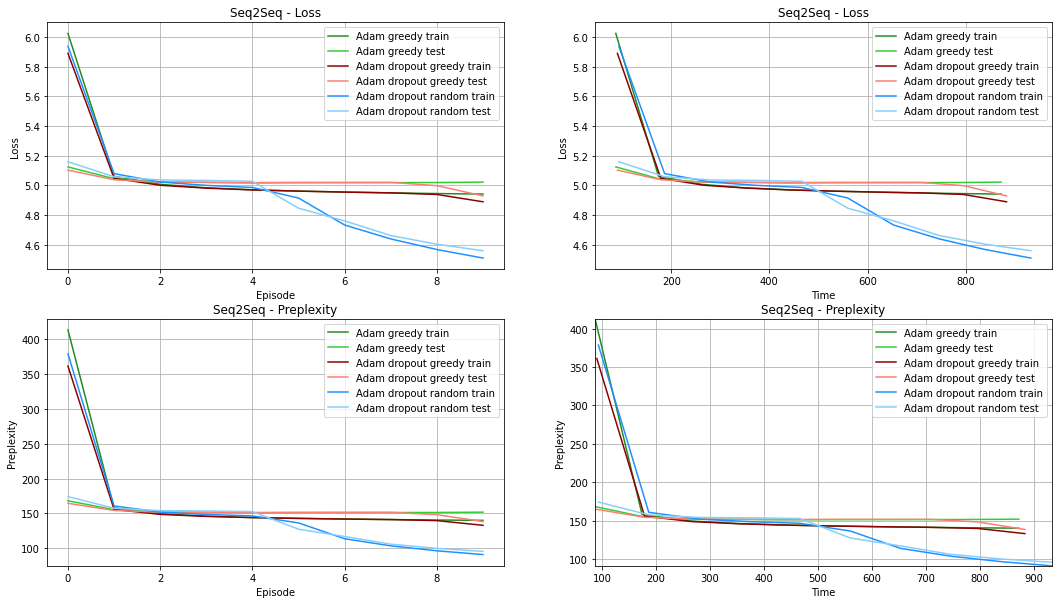

In [20]:
cmap = plt.get_cmap('viridis')
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 10))

loss_ax, loss_time_ax = ax[0]
pre_ax, pre_time_ax = ax[1]

loss_ax.grid(True)
loss_time_ax.grid(True)
pre_ax.grid(True)
pre_time_ax.grid(True)
plt.margins(0)

loss_ax.set_title("Seq2Seq - Loss")
loss_ax.set_xlabel("Episode")
loss_ax.set_ylabel("Loss")

loss_time_ax.set_title("Seq2Seq - Loss")
loss_time_ax.set_xlabel("Time")
loss_time_ax.set_ylabel("Loss")


pre_ax.set_title("Seq2Seq - Preplexity")
pre_ax.set_xlabel("Episode")
pre_ax.set_ylabel("Preplexity")

pre_time_ax.set_title("Seq2Seq - Preplexity")
pre_time_ax.set_xlabel("Time")
pre_time_ax.set_ylabel("Preplexity")


file = "/content/seq2seq-adam-dropout_False-strategy_greedy.json"
name = "Adam greedy"
train_color = "forestgreen"
test_color = "limegreen"
add_to_plot(file, name, train_color, test_color, loss_ax, loss_time_ax, pre_ax, pre_time_ax)

""""""""""""""""""""""""""""""""""""""""""

file = "/content/seq2seq-adam-dropout_True-strategy_greedy.json"
name = "Adam dropout greedy"
train_color = "darkred"
test_color = "salmon"
add_to_plot(file, name, train_color, test_color, loss_ax, loss_time_ax, pre_ax, pre_time_ax)


""""""""""""""""""""""""""""""""""""""""""

file = "/content/seq2seq-adam-dropout_True-strategy_random.json"
name = "Adam dropout random"
train_color = "dodgerblue"
test_color = "lightskyblue"
add_to_plot(file, name, train_color, test_color, loss_ax, loss_time_ax, pre_ax, pre_time_ax)

""""""""""""""""""""""""""""""""""""""""""

# file = "/content/seq2seq-sgd-dropout_True-strategy_greedy.json"
# name = "Sdg dropout greedy"
# train_color = "purple"
# test_color = "violet"
# add_to_plot(file, name, train_color, test_color, loss_ax, loss_time_ax, pre_ax, pre_time_ax)


loss_ax.legend()
loss_time_ax.legend()
pre_time_ax.legend()
pre_ax.legend()

## Transformer

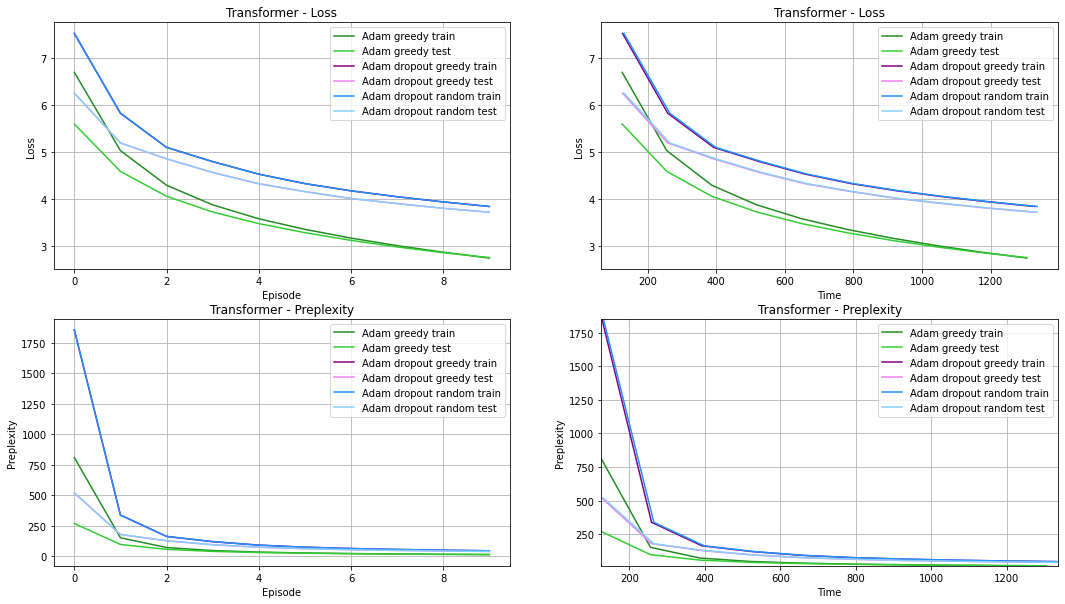

In [21]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 10))

loss_ax, loss_time_ax = ax[0]
pre_ax, pre_time_ax = ax[1]

loss_ax.grid(True)
loss_time_ax.grid(True)
pre_ax.grid(True)
pre_time_ax.grid(True)
plt.margins(0)

loss_ax.set_title("Transformer - Loss")
loss_ax.set_xlabel("Episode")
loss_ax.set_ylabel("Loss")

loss_time_ax.set_title("Transformer - Loss")
loss_time_ax.set_xlabel("Time")
loss_time_ax.set_ylabel("Loss")

pre_ax.set_title("Transformer - Preplexity")
pre_ax.set_xlabel("Episode")
pre_ax.set_ylabel("Preplexity")

pre_time_ax.set_title("Transformer - Preplexity")
pre_time_ax.set_xlabel("Time")
pre_time_ax.set_ylabel("Preplexity")


file = "/content/transformer-adam-dropout_False-strategy_greedy.json"
name = "Adam greedy"
train_color = "forestgreen"
test_color = "limegreen"
add_to_plot(file, name, train_color, test_color, loss_ax, loss_time_ax, pre_ax, pre_time_ax)

""""""""""""""""""""""""""""""""""""""""""

file = "/content/transformer-adam-dropout_True-strategy_greedy.json"
name = "Adam dropout greedy"
train_color = "purple"
test_color = "violet"
add_to_plot(file, name, train_color, test_color, loss_ax, loss_time_ax, pre_ax, pre_time_ax)

""""""""""""""""""""""""""""""""""""""""""

file = "/content/transformer-adam-dropout_True-strategy_random.json"
name = "Adam dropout random"
train_color = "dodgerblue"
test_color = "lightskyblue"
add_to_plot(file, name, train_color, test_color, loss_ax, loss_time_ax, pre_ax, pre_time_ax)

""""""""""""""""""""""""""""""""""""""""""

# file = "/content/transformer-sgd-dropout_True-strategy_greedy.json"
# name = "Sdg dropout greedy"
# train_color = "purple"
# test_color = "violet"
# add_to_plot(file, name, train_color, test_color, loss_ax, loss_time_ax, pre_ax, pre_time_ax)


loss_ax.legend()
loss_time_ax.legend()
pre_time_ax.legend()
pre_ax.legend()